# Gene Feature Selection

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import bokeh.plotting as bpl
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
# import pandas as pd
# import seaborn as sn

# Sparse Regression model
## For Gene Selection
- $X\in\mathbb{R}^{n\times d}$ is the observed gene data
- $\beta\in\mathbb{R}^d$ is the coefficient vector
- $y\in\mathbb{R}^n$ is the observed disease class
- We want to solve the $l_1$ minimization problem
$$\text{min}_{\beta}\|\beta\|_1\text{ s.t. } X\beta=y$$
- Then to deal with noise, we extend the problem to a Lasso problem, whose objective function is
$$\text{min}_\beta\lambda\|\beta\|_1+\frac{1}{2}\|X\beta-y\|_2^2$$
- This model uses the proximal gradient method


In [350]:
class sparseRegressionLasso:
    def __init__(self, X, y, lam, iterationNum):
#         print("Initialization")
        self.X = X
        self.y = y
        self.XT = self.X.T
        self.lam = lam
        self.iterationNum = iterationNum
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.beta = np.random.rand(self.d)
        self.objectList = np.zeros(self.iterationNum)
        norm = np.linalg.norm(self.X) ** 2
        self.alpha = 1/norm
#         print("alpha", self.alpha)
#         eigenvalues, eigenvectors = np.linalg.eig(np.matmul(self.XT, self.X))
#         eigenvalues = np.abs(eigenvalues)
#         self.alpha = 1/np.max(eigenvalues)
#         print("Finish Initialization")
        
    def objectiveFunction(self):
        obj = self.lam * np.sum(np.abs(self.beta))
        obj += 0.5*np.power(np.linalg.norm(np.matmul(self.X, self.beta)-self.y),2)
        return obj
    
    def nablaFbeta(self):
        second = np.matmul(self.X, self.beta)
        second = second - self.y
        return np.matmul(self.XT, second)
    
    def train(self):
        for k in range(self.iterationNum):
#             if k % (self.iterationNum/10) == 0:
#                 print(k / (self.iterationNum/10))
            nablaFbeta = self.nablaFbeta()
            wk = self.beta - self.alpha*nablaFbeta
            ind = np.where(np.abs(wk)-self.alpha*self.lam > 0)
            self.beta[ind] = (wk[ind] - np.sign(wk[ind])*self.alpha*self.lam)
            ind = np.where(np.abs(wk)-self.alpha*self.lam <= 0)
            self.beta[ind] = 0
            self.objectList[k] = self.objectiveFunction()

        return self.beta, self.objectList
    
    def plotObjectiveList(self):
        bpl.output_notebook()
        h = bpl.figure(title="Objective value versus iteration round number")
        h.xaxis.axis_label = 'Iteration Round Number'
        h.yaxis.axis_label = 'Object Value'
        h.line(np.arange(self.iterationNum-1),
               self.objectList[1:])
        bpl.show(h)
        return self
    
    def plotBetaStem(self):
        plt.stem(np.abs(self.beta), use_line_collection=True)
        plt.xlabel("gene location")
        plt.ylabel("coefficient")
        plt.show()
        return self
        
    def plotResult(self):
        self.plotObjectiveList()0.07
        self.plotBetaStem()
        return self
 

# Classification Model with the Selected Genes

In [608]:
# Input data should have already been feature-selected
def SelectedTest(Data, Label, lam, iterationNum, Verb=False):
    Data, Label = shuffle(Data, Label)
    trainSize = np.floor(Data.shape[0] * 0.75).astype(int)
    testSize = len(Label) - trainSize
    model = sparseRegressionLasso(X = Data[0:trainSize], y = Label[0:trainSize], lam = lam, iterationNum = iterationNum)
    model.train()
#     model.plotResult()
    result = Data[trainSize:] @ model.beta
    result[np.where(result >= 0)] = 1
    result[np.where(result < 0)] = -1
    error_rate = len(np.where(result != Label[trainSize:])[0]) / len(result) * 100
    if Verb:
        print(result)
        print(Label[trainSize:])
    return error_rate

## Run on E-TABM-185 Dataset

In [596]:
ALL = list(range(1108, 1207)) + list(range(1324, 1345)) + list(range(3479, 3489)) + list(range(3489, 3499)) + list(range(4050, 4052))\
    +list(range(5625, 5637))+[5647,5658,5669,5680,5691,5702,5713,5724,2735]+list(range(5746,5898))
ALL = np.asarray(ALL)-2

AML = list(range(2228, 2234)) + list(range(2956,2958)) + list(range(2965,3256)) + list(range(3567, 3610))
AML = np.asarray(AML)-2

CML = list(range(1304, 1324)) + list(range(1345, 1390))
CML = np.asarray(CML)-2

geneSize = 22283
ALL_Data = np.zeros((len(ALL), geneSize))
AML_Data = np.zeros((len(AML), geneSize))
CML_Data = np.zeros((len(CML), geneSize))
GENE_IDs = []

f = open('data/E-TABM-185/microarray.original.txt', 'r')
line = f.readline()
count = 0
while True:
    line = f.readline()
    if line:
        lineSplit = line.split("\t")
        GENE_IDs.append(lineSplit[0])
        lineList = np.asarray(list(map(float, lineSplit[1:])))
        ALL_Data[:,count] = lineList[ALL]
        AML_Data[:,count] = lineList[AML]
        CML_Data[:,count] = lineList[CML]
        count += 1
    else: break
    
f.close()
print(count)
print("GENE_IDs", len(GENE_IDs))



22283
GENE_IDs 22283


In [342]:
# np.savetxt('ALL_Data.csv', ALL_Data, delimiter=',')
# np.savetxt('AML_Data.csv', AML_Data, delimiter=',')
# np.savetxt('CML_Data.csv', CML_Data, delimiter=',')

In [343]:
# Normalization
ALL_DataNormalized = normalize(ALL_Data)
print("ALL", ALL_DataNormalized.shape)

AML_DataNormalized = normalize(AML_Data)
print("AML", AML_DataNormalized.shape)

CML_DataNormalized = normalize(CML_Data)
print("CML", CML_DataNormalized.shape)

classArrayUnshuffled = np.hstack((np.full(len(ALL_DataNormalized), -1), np.full(len(AML_DataNormalized), 1)))
# classArrayUnshuffled = np.hstack((classArrayUnshuffled, np.full(len(CML_DataNormalized), 2)))
# print("class", classArray.shape)
DataUnshuffled = np.vstack((ALL_DataNormalized, AML_DataNormalized))
# DataUnshuffled = np.vstack((DataUnshuffled, CML_DataNormalized))
print(DataUnshuffled.shape)

ALL (315, 22283)
AML (342, 22283)
CML (65, 22283)
(657, 22283)


X (657, 22283)
y (657,)


Loading BokehJS ...

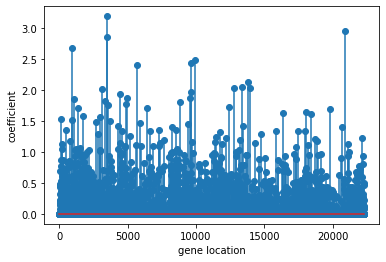

Loading BokehJS ...

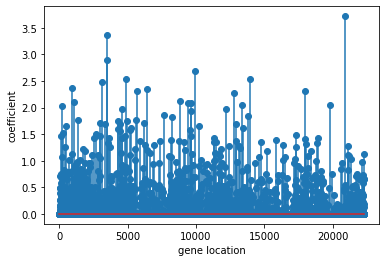

Loading BokehJS ...

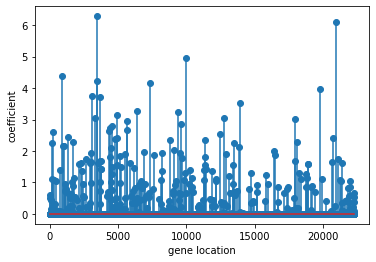

Loading BokehJS ...

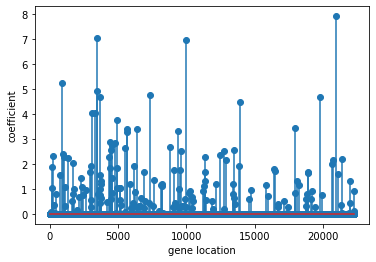

Loading BokehJS ...

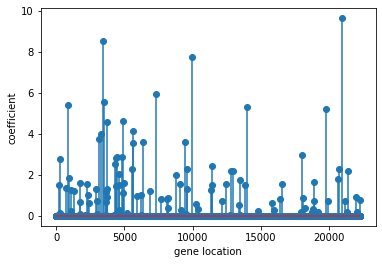

Loading BokehJS ...

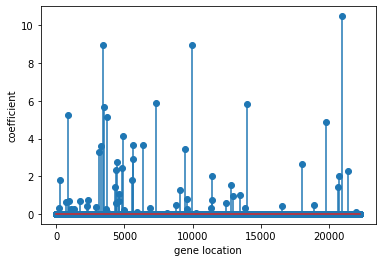

Loading BokehJS ...

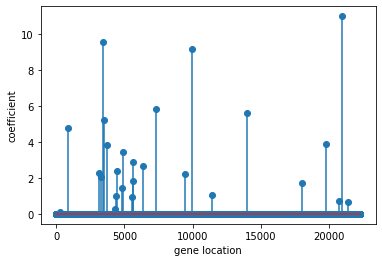

Loading BokehJS ...

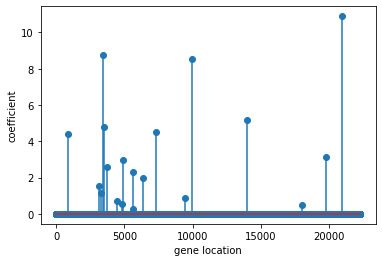

Loading BokehJS ...

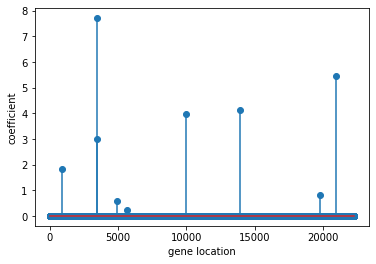

Loading BokehJS ...

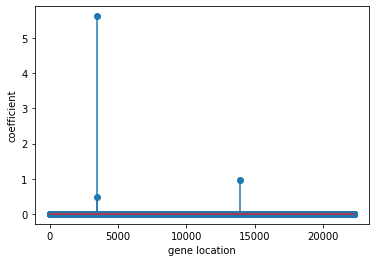

Loading BokehJS ...

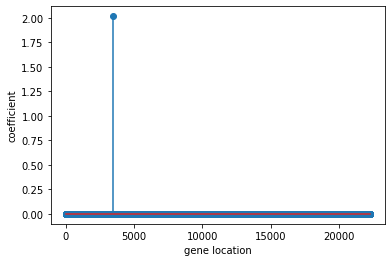

Loading BokehJS ...

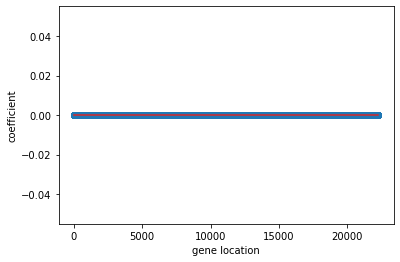

In [527]:
Data, classArray = shuffle(DataUnshuffled, classArrayUnshuffled)
# X = Data[0:500]
# y = classArray[0:500]
X = Data
y = classArray
print("X", X.shape)
print("y", y.shape)
lamList = [0.07, 0.1, 0.3, 0.5, 0.7, 1.0, 1.3, 1.5, 2.0, 2.5, 3.0, 5.0]
iterationNum = 10000

modelList = []
for lam in lamList:
    model = sparseRegressionLasso(X = X, y = y, lam = lam, iterationNum = iterationNum)
    model.train()
    model.plotResult()
    modelList.append(model)

## Use Selected Gene to Build Classification Algorithm on E-TABM-185 Dataset

In [528]:
error_rate_list = np.zeros(len(modelList))
for k in range(len(modelList)):
    model = modelList[k]
    print("lam = {}".format(model.lam))
    bestInd = np.where(np.abs(model.beta) > 0)[0]
    print("number of selected genes: {}".format(len(bestInd)))
    testData = Data[:,bestInd]
    error_rate = 0
    for i in range(5):
        error_rate_cur = SelectedTest(testData, classArray, 0.1, 5000)
        print("round {}, error rate = {}".format(i, error_rate_cur))
        error_rate += error_rate_cur
    error_rate_list[k] = error_rate/5
    print("error rate = {}".format(error_rate_list[k]))


lam = 0.07
number of selected genes: 1531
round 0, error rate = 0.6060606060606061
round 1, error rate = 1.8181818181818181
round 2, error rate = 0.6060606060606061
round 3, error rate = 0.0
round 4, error rate = 2.4242424242424243
error rate = 1.090909090909091
lam = 0.1
number of selected genes: 1001
round 0, error rate = 1.8181818181818181
round 1, error rate = 0.6060606060606061
round 2, error rate = 0.6060606060606061
round 3, error rate = 0.6060606060606061
round 4, error rate = 0.6060606060606061
error rate = 0.8484848484848484
lam = 0.3
number of selected genes: 275
round 0, error rate = 1.2121212121212122
round 1, error rate = 1.2121212121212122
round 2, error rate = 0.6060606060606061
round 3, error rate = 1.2121212121212122
round 4, error rate = 0.6060606060606061
error rate = 0.9696969696969697
lam = 0.5
number of selected genes: 164
round 0, error rate = 1.8181818181818181
round 1, error rate = 1.2121212121212122
round 2, error rate = 3.0303030303030303
round 3, error rate

/Users/camelboat/Desktop/ELEN_6876_Sparse_Model_for_HI-D_Data/Homeworks/Homework_1/hwVenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


round 0, error rate = 52.121212121212125
round 1, error rate = 48.484848484848484
round 2, error rate = 48.484848484848484
round 3, error rate = 42.42424242424242
round 4, error rate = 46.666666666666664
error rate = 47.63636363636363


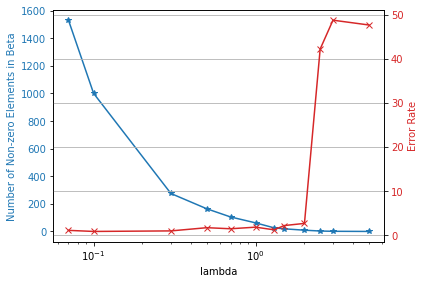

In [593]:
betaNumberList = [1531, 1001, 275, 164, 105, 62, 26, 19, 9, 3, 1, 0]
fig, ax1 = plt.subplots()
color = 'tab:blue'

ax1.set_xlabel('lambda')
ax1.set_ylabel('Number of Non-zero Elements in Beta', color=color)
ax1.plot(lamList, betaNumberList, '*-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Error Rate', color=color)
ax2.plot(lamList, error_rate_list, 'x-', color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()


plt.xscale('log')
plt.grid('on')
plt.show()


In [303]:
def SVMTest(Data, Label, Verb=False):
    Data, Label = shuffle(Data, Label)
    clf = svm.SVC()
    trainSize = np.floor(Data.shape[0] * 0.75).astype(int)
    clf.fit(Data[0:trainSize], Label[0:trainSize])
    result = clf.predict(Data[trainSize:])
    error_rate = len(np.where(result - Label[trainSize:] != 0)[0]) / len(result) * 100
    if Verb:
        print("training set size: {}".format(trainSize))
        print("test set size: {}".format(len(Label)-trainSize))
        print("Res", result)
        print("True", Label[trainSize:])
        print("Error Rate: {}%".format(error_rate))
    return error_rate


In [556]:
# GENE_IDs_Best = []
# for ind in bestInd:
#     GENE_IDs_Best.append(GENE_IDs[ind])
# print(len(GENE_IDs_Best))
# print(GENE_IDs_Best)

bestGeneList = []
bestGeneIndList = []
for i in range(3,7):
    model = modelList[i]
    beta = model.beta
    bestInd = np.where(np.abs(beta) > 0)[0]
    bestIndSorted = bestInd[np.argsort(-beta[bestInd])]
    print("lam = {}, number of non-zero elements in beta: {}".format(model.lam, len(bestInd)))
    bestGene = []
    for ind in bestIndSorted:
        bestGene.append(GENE_IDs[ind])
    print(bestGene)
    maxInd = np.where(beta == np.amax(beta))[0]
    print("maxInd{}".format(maxInd))
    print(GENE_IDs[maxInd[0]])
    bestGeneList.append(bestGene)
    bestGeneIndList.append(bestInd)

bestGeneSet = set(bestGeneList[0])
bestGeneIndSet = set(bestGeneIndList[0])
for GeneList in bestGeneList:
    bestGeneSet = set(GeneList) & bestGeneSet
print("Best Genes: {}".format(bestGeneSet))
for GeneIndList in bestGeneIndList:
    bestGeneIndSet = set(GeneIndList) & bestGeneIndSet
print("Best Genes Ind: {}".format(bestGeneIndSet))




lam = 0.5, number of non-zero elements in beta: 164
['"203948_s_at"', '"201360_at"', '"203949_at"', '"220416_at"', '"214575_s_at"', '"203591_s_at"', '"203799_at"', '"205382_s_at"', '"218618_s_at"', '"206871_at"', '"206111_at"', '"209930_s_at"', '"206120_at"', '"205051_s_at"', '"209318_x_at"', '"214085_x_at"', '"210136_at"', '"213395_at"', '"200742_s_at"', '"201536_at"', '"203470_s_at"', '"214450_at"', '"206674_at"', '"200661_at"', '"205418_at"', '"217022_s_at"', '"210084_x_at"', '"207341_at"', '"221766_s_at"', '"204122_at"', '"208151_x_at"', '"204232_at"', '"218718_at"', '"206380_s_at"', '"208703_s_at"', '"216474_x_at"', '"218847_at"', '"208719_s_at"', '"205624_at"', '"215382_x_at"', '"203126_at"', '"206715_at"', '"210754_s_at"', '"213998_s_at"', '"219452_at"', '"204039_at"', '"200900_s_at"', '"220560_at"', '"204150_at"', '"202626_s_at"', '"204222_s_at"', '"207134_x_at"', '"215236_s_at"', '"210449_x_at"', '"204971_at"', '"205608_s_at"', '"203471_s_at"', '"212526_at"', '"207761_s_at"', 

In [557]:
error_rate = 0
for i in range(10):
    testData = Data[:, list(bestGeneIndSet)]
    bestErrorRate = SelectedTest(testData, classArray, 0.001, 5000)
    error_rate += bestErrorRate
    print("error rate on the best {} genes is {}".format(len(list(bestGeneIndSet)), bestErrorRate))
print("average error rate on best genes is {}".format(error_rate / 10))

error rate on the best 26 genes is 2.4242424242424243
error rate on the best 26 genes is 1.8181818181818181
error rate on the best 26 genes is 1.8181818181818181
error rate on the best 26 genes is 2.4242424242424243
error rate on the best 26 genes is 1.8181818181818181
error rate on the best 26 genes is 1.8181818181818181
error rate on the best 26 genes is 1.8181818181818181
error rate on the best 26 genes is 3.6363636363636362
error rate on the best 26 genes is 1.8181818181818181
error rate on the best 26 genes is 1.8181818181818181
average error rate on best genes is 2.1212121212121207


## Simple SVM Test on the Result of Gene Selection on E-TABM-185 Dataset

In [595]:
# bestInd = np.where(np.abs(model.beta) > 0.1)[0]
print("number of selected gene locations: {}\n".format(len(list(bestGeneIndSet))))
originError = 0
selectError = 0
for i in range(100):
#     print(i)
    originError += SVMTest(X, y)
    selectError += SVMTest(X[:,list(bestGeneIndSet)], y)
print("Error rate on original data: {}".format(originError/100))
print("Error rate on selected data: {}".format(selectError/100))

number of selected gene locations: 26

Error rate on original data: 0.4121212121212123
Error rate on selected data: 1.545454545454545


## Run on Golub et al.'s Dataset

In [601]:
# Read Data
firstSampleSize = 38
secondSampleSize = 72-38
GolubSampleNum = 72
GolubGeneSize = 7129
GolubData = np.zeros((GolubSampleNum, GolubGeneSize))
GolubDataInd = np.zeros(GolubSampleNum)
GolubDataClass = np.zeros(GolubSampleNum)
GolubGeneDescription = []
GolubGeneAccessionNumber = []

f = open('data/Golub/data_set_ALL_AML_train.csv', 'r')
line = f.readline()
GolubDataInd = np.asarray(list(map(int, line.split(",")[2:][::2])))
for i in range(GolubGeneSize):
    line = f.readline()
    if line:
        lineSplit = line.split(",")
        GolubGeneDescription.append(lineSplit[0])
        GolubGeneAccessionNumber.append(lineSplit[1])
        GolubData[0:firstSampleSize,i] = np.asarray(list(map(float, lineSplit[2:][::2])))
    else: break
f.close()

f = open('data/Golub/data_set_ALL_AML_independent.csv', 'r')
line = f.readline()
GolubDataInd2 = np.asarray(list(map(int, line.split(",")[2:][::2])))
for i in range(GolubGeneSize):
    line = f.readline()
    if line:
        lineSplit = line.split(",")
        GolubData[firstSampleSize:,i] = np.asarray(list(map(float, lineSplit[2:][::2])))
    else: break
f.close()

GolubDataInd = np.hstack((GolubDataInd, GolubDataInd2))

f = open('data/Golub/actual.csv', 'r')
line = f.readline()
for i in range(GolubSampleNum):
    line = f.readline()
    label = line.split(",")[1]
    if label == "ALL\n":
        GolubDataClass[i] = -1
    else:
        GolubDataClass[i] = 1
f.close()


lam = 0.0001


Loading BokehJS ...

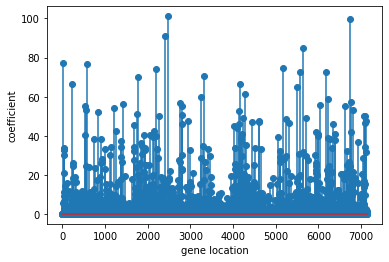

lam = 0.0003


Loading BokehJS ...

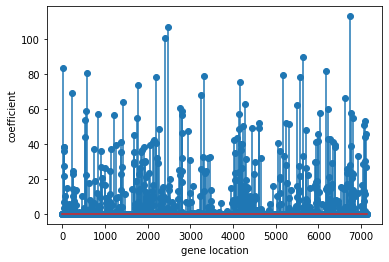

lam = 0.0005


Loading BokehJS ...

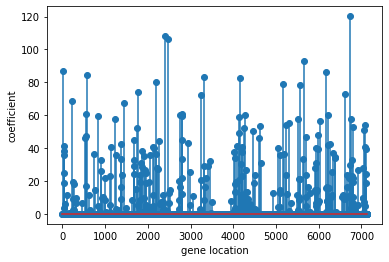

lam = 0.0007


Loading BokehJS ...

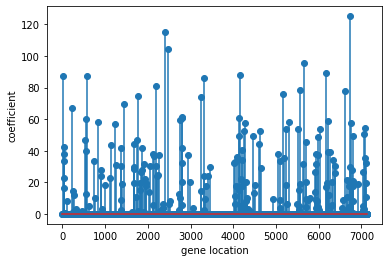

lam = 0.001


Loading BokehJS ...

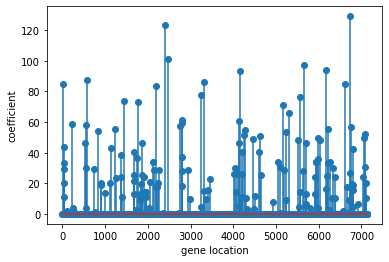

lam = 0.003


Loading BokehJS ...

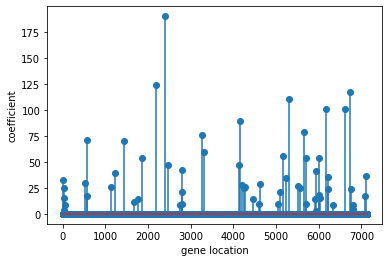

lam = 0.005


Loading BokehJS ...

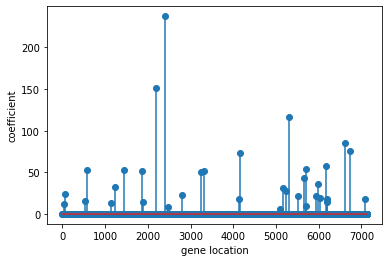

lam = 0.007


Loading BokehJS ...

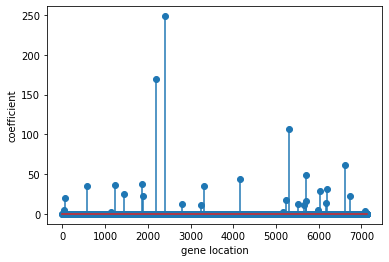

lam = 0.01


Loading BokehJS ...

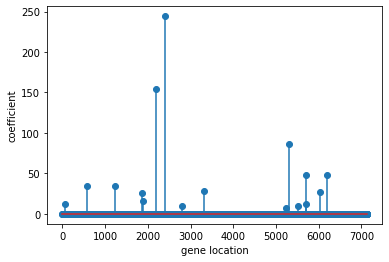

lam = 0.03


Loading BokehJS ...

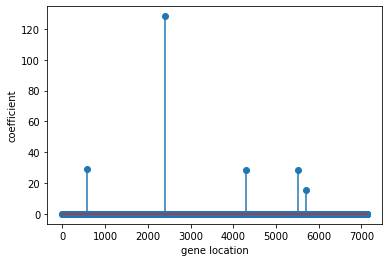

lam = 0.05


Loading BokehJS ...

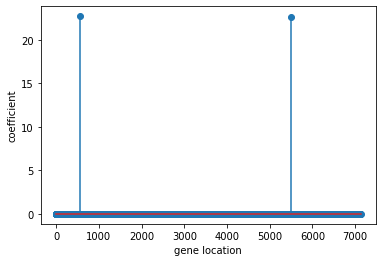

In [602]:
###### GolubDataNormalized = GolubData / (np.sum(GolubData, axis=1, keepdims=True))

GolubIterationNum = 10000

GolubLamList = [0.0001, 0.0003, 0.0005, 0.0007, 0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05]
GolubModelList = []
for i in range(len(GolubLamList)):
    GolubLam = GolubLamList[i]
    GolubModel = sparseRegressionLasso(X = GolubDataNormalized, 
                                       y = GolubDataClass,
                                       lam = GolubLam,
                                       iterationNum = GolubIterationNum)
    GolubModelList.append(GolubModel)
    GolubBetaList[i,:], GolubObjectList = GolubModel.train()
    print("lam = {}".format(GolubLam))
    GolubModel.plotResult()

for i in range(GolubBetaList.shape[1]):
    GolubBetaIList = GolubBetaList[:,i]
    plt.plot(GolubLamList, GolubBetaIList)
plt.xscale('log')
plt.xlabel('Regularization Parameter Lambda')
plt.ylabel('Coefficients') 
plt.show()

In [603]:
GolubBestGeneList = []
GolubBestGeneIndList = []
for i in range(5,9):
    model = GolubModelList[i]
    GolubBeta = model.beta
    GolubBestInd = np.where(np.abs(GolubBeta) > 0)[0]
    GolubBestIndSorted = GolubBestInd[np.argsort(-GolubBeta[GolubBestInd])]
    print("lam = {}, number of non-zero elements in beta: {}".format(model.lam, len(GolubBestInd)))
    GolubBestGene = []
    for ind in GolubBestIndSorted:
        GolubBestGene.append(GolubGeneAccessionNumber[ind])
    print(GolubBestGene)
    GolubMaxInd = np.where(GolubBeta == np.amax(GolubBeta))[0]
    print(GolubGeneAccessionNumber[GolubMaxInd[0]])
    GolubBestGeneList.append(GolubBestGene)
    GolubBestGeneIndList.append(GolubBestInd)

GolubBestGeneSet = set(GolubBestGeneList[0])
GolubBestGeneIndSet = set(GolubBestGeneIndList[0])
for GeneList in GolubBestGeneList:
    GolubBestGeneSet = set(GeneList) & GolubBestGeneSet
print("Best Genes: {}".format(GolubBestGeneSet))
for GeneIndList in GolubBestGeneIndList:
    GolubBestGeneIndSet = set(GeneIndList) & GolubBestGeneIndSet
print("Best Genes Ind: {}".format(GolubBestGeneIndSet))


lam = 0.003, number of non-zero elements in beta: 58
['M96326_rna1_at', 'M69043_at', 'M21305_at', 'M13560_s_at', 'Z48501_s_at', 'U46751_at', 'L26247_at', 'Z48950_at', 'X03689_s_at', 'M25079_s_at', 'M26602_at', 'X14046_at', 'S73591_at', 'V00594_s_at', 'Z19554_s_at', 'Z84721_cds2_at', 'hum_alu_at', 'X78992_at', 'X17042_at', 'X55715_at', 'J04990_at', 'D13666_s_at', 'M27783_s_at', 'M17885_at', 'X67247_rna1_at', 'X78136_at', 'HG1428-HT1428_s_at', 'U12404_at', 'M19045_f_at', 'M63438_s_at', 'J03801_f_at', 'AFFX-HUMGAPDH/M33197_5_at', 'M87789_s_at', 'AFFX-M27830_5_at', 'U14969_at', 'Z12962_at', 'M11353_at', 'M10277_s_at', 'AFFX-HUMGAPDH/M33197_3_at', 'L04483_s_at', 'D78361_at', 'M60750_f_at', 'J04617_s_at', 'U15008_at', 'Z23090_at', 'L11672_at', 'X52851_rna1_at', 'AFFX-HUMRGE/M10098_3_at', 'D86974_at', 'D63874_at', 'X01677_f_at', 'L06499_at', 'U14973_at', 'U49869_rna1_at', 'D79205_at', 'D49824_s_at', 'X15183_at', 'L20688_at']
M96326_rna1_at
lam = 0.005, number of non-zero elements in beta: 34


## Use Selected Gene to Build Classification Algorithm on Golub et al.'s Dataset

In [604]:
GolubErrorRate = np.zeros(len(GolubLamList))
GolubBetaNumberList = np.zeros(len(GolubLamList))
# for model in GolubModelList:
for k in range(len(GolubModelList)):
    model = GolubModelList[k]
    bestInd = np.where(np.abs(model.beta) > 0)[0]
    print("lam = {}".format(model.lam))
    print("number of selected genes: {}".format(len(bestInd)))
    GolubBetaNumberList[k] = len(bestInd)
    testData = GolubDataNormalized[:,bestInd-1]
    error_rate = 0
    for i in range(20):
        error_rate_cur = SelectedTest(testData, GolubDataClass, 0.001, 5000)
        error_rate += error_rate_cur
#         print("round {}, error rate = {}".format(i, error_rate_cur))
    error_rate = error_rate / 20
    GolubErrorRate[k] = error_rate
    print("average error rate = {}".format(error_rate))


lam = 0.0001
number of selected genes: 1355
average error rate = 25.0
lam = 0.0003
number of selected genes: 459
average error rate = 20.83333333333333
lam = 0.0005
number of selected genes: 293
average error rate = 20.0
lam = 0.0007
number of selected genes: 220
average error rate = 25.555555555555554
lam = 0.001
number of selected genes: 158
average error rate = 27.5
lam = 0.003
number of selected genes: 58
average error rate = 32.50000000000001
lam = 0.005
number of selected genes: 34
average error rate = 22.77777777777778
lam = 0.007
number of selected genes: 28
average error rate = 29.166666666666675
lam = 0.01
number of selected genes: 17
average error rate = 24.166666666666664
lam = 0.03
number of selected genes: 5
average error rate = 35.00000000000001
lam = 0.05
number of selected genes: 2
average error rate = 36.11111111111112


In [605]:
error_rate = 0
for i in range(20):
    testData = GolubDataNormalized[:, list(GolubBestGeneIndSet)]
    GolubBestErrorRate = SelectedTest(testData, GolubDataClass, 0.001, 5000)
    error_rate += GolubBestErrorRate
#     print("error rate on the best {} genes is {}".format(len(list(GolubBestGeneIndSet)), GolubBestErrorRate))
print("average error rate on best genes is {}".format(error_rate / 20))



average error rate on best genes is 20.55555555555555


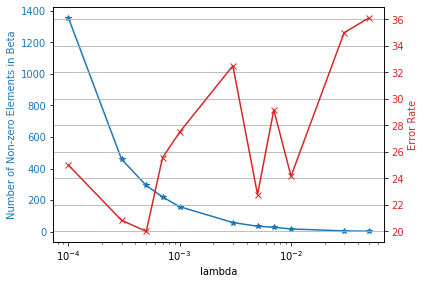

In [606]:
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('lambda')
ax1.set_ylabel('Number of Non-zero Elements in Beta', color=color)
ax1.plot(GolubLamList, GolubBetaNumberList, '*-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Error Rate', color=color)
ax2.plot(GolubLamList, GolubErrorRate, 'x-', color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

plt.xscale('log')
plt.grid('on')
plt.show()

# fig, ax1 = plt.subplots()

# color = 'tab:red'
# ax1.set_xlabel('time (s)')
# ax1.set_ylabel('exp', color=color)
# ax1.plot(t, data1, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

## Simple SVM Test on the Result of Gene Selection on Golub et al.'s Dataset

In [607]:
GolubOriginErrorRate = 0
GolubSelectErrorRate = 0
for i in range(100):
    GolubOriginErrorRate += SVMTest(GolubDataNormalized, GolubDataClass)
    GolubSelectErrorRate += SVMTest(GolubDataNormalized[:,GolubBestInd], GolubDataClass)

print("SVM test average error rate on Golub original data: {}".format(GolubOriginErrorRate/100))
print("SVM test average error rate on Golub selected data: {}".format(GolubSelectErrorRate/100))


SVM test average error rate on Golub original data: 34.777777777777764
SVM test average error rate on Golub selected data: 22.000000000000004
